In [1]:
# We will try to use only 1 key value of y (y_min) as a feature, instead of using all of the values of y.
# There will be no noise in the values of y.

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [4]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
  plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show() 

In [5]:
l_min = 1
l_max = 1

n_l = 1  # defined only one value for L, for now.

# q in kN
q_min = 100
q_max = 500

n_q = 80

# E in GPa
E_min = 100
E_max = 350

n_E = 80

# I in dm^4
I_min = 1 * 10 ** 3 
I_max = 5 * 10 ** 3

n_I = 80

# Will make the vectors linearly spaced, but it's not necessary
l_vec = np.linspace(l_min, l_max, n_l)
q_vec = np.linspace(q_min, q_max, n_q)
E_vec = np.linspace(E_min, E_max, n_E)
I_vec = np.linspace(I_min, I_max, n_I)

In [6]:
# Compute all possible permutations and arrange them in a matrix

# Possibility to add noise to the values of q, E, I.
noise = 0.0

per_list = []
for i in range(len(l_vec)):
    for j in range(len(q_vec)):
        for k in range(len(E_vec)):
            for l in range(len(I_vec)):
                q_vec[j] = q_vec[j] + noise * (np.random.random() - 0.5) * (q_max - q_min)
                E_vec[k] = E_vec[k] + noise * (np.random.random() - 0.5) * (E_max - E_min)
                I_vec[l] = I_vec[l] + noise * (np.random.random() - 0.5) * (I_max - I_min)
                
                per_list = np.append(per_list, np.array([[l_vec[i], q_vec[j], E_vec[k], I_vec[l]]]))

per_list = per_list.reshape(-1, 4)

# Shuffle the permutations
np.random.shuffle(per_list)

np.save('125_combinations', per_list)  # saved as an .npy file to use later using np.load('125_combinations')

In [7]:
# analytical solution for the beam bending problem

def ana_sol(n, param_list):
    l=param_list[0]
    q=param_list[1]
    E=param_list[2]
    I=param_list[3]
    x_min = 0
    x_max = l
    x = np.linspace(x_min, x_max, n)
    y = np.zeros(len(x))
    c_1 = -(q * 10 ** 3 * l ** 3) / (24 * E * 10 ** 9 * I * 10 ** (-8))
    y = (1 / (E * 10 ** 9 * I * 10 ** (-8))) * (((q * 10 ** 3 * l) / 12) * x ** 3 - (q * 10 ** 3 / 24) * x ** 4) + c_1 * x

    return [x, y]

def ana_sol_with_noise(n, param_list,noise):
    l=param_list[0]
    q=param_list[1]
    E=param_list[2]
    I=param_list[3]
    x_min = 0
    x_max = l
    x = np.linspace(x_min, x_max, n)
    y = np.zeros(len(x))
    c_1 = -(q * 10 ** 3 * l ** 3) / (24 * E * 10 ** 9 * I * 10 ** (-8))
    y = (1 / (E * 10 ** 9 * I * 10 ** (-8))) * (((q * 10 ** 3 * l) / 12) * x ** 3 - (q * 10 ** 3 / 24) * x ** 4) + c_1 * x
    y = y + noise * (np.random.random(len(y)) - 0.5) * (np.max(y) - np.min(y))

    return [x, y]

In [8]:
#alternative way to generate fake data with noise
n = 1000
# Add noise
noise_factor = 0.0
#create dictionary with generated data
fake_data = {}
#dict keys: list of parameters values
#dict values: (x,y) array 
for i in per_list:
    fake_data[repr(i.tolist())] = ana_sol_with_noise(n, i, noise_factor)

In [9]:
#for each entry combination of (l,q,E,I) we have two columns of fake data: both x and noisy y 
fake_dataframe=pd.DataFrame.from_dict(fake_data,orient='index',columns=['x', 'y'])
#I will now dstructure the data in such a way that we are able to immediatly assess 
# which entry combination of (l,q,E,I) gives a specific (x,Y)
#let's clean a little
fake_dataframe=fake_dataframe.rename_axis('parameters').reset_index()
fake_dataframe.parameters=[eval(fake_dataframe.parameters[i]) for i in range(len(fake_dataframe))]
fake_dataframe[['l','q','E','I']] = pd.DataFrame(fake_dataframe.parameters.tolist(), index= fake_dataframe.index)
fake_dataframe=fake_dataframe.drop(columns='parameters')
#let's see an example of structured data
fake_dataframe

,x,y,l,q,E,I
0,"[0.0, 0.001001001001001001, 0.0020020020020020...","[0.0, -9.45556684953274e-07, -1.89110201375372...",1.0,231.645570,210.759494,4848.101266
1,"[0.0, 0.001001001001001001, 0.0020020020020020...","[0.0, -1.786169827766289e-06, -3.5723182036007...",1.0,449.367089,315.189873,3329.113924
2,"[0.0, 0.001001001001001001, 0.0020020020020020...","[0.0, -1.4428029653691148e-06, -2.885588602648...",1.0,444.303797,267.721519,4797.468354
3,"[0.0, 0.001001001001001001, 0.0020020020020020...","[0.0, -2.555511376845738e-06, -5.1109920619537...",1.0,175.949367,220.253165,1303.797468
4,"[0.0, 0.001001001001001001, 0.0020020020020020...","[0.0, -7.462277238183966e-07, -1.4924464854283...",1.0,105.063291,179.113924,3278.481013
...,...,...,...,...,...,...
511995,"[0.0, 0.001001001001001001, 0.0020020020020020...","[0.0, -2.5769224497629466e-06, -5.153813950640...",1.0,358.227848,185.443038,3126.582278
511996,"[0.0, 0.001001001001001001, 0.0020020020020020...","[0.0, -1.775617942416164e-06, -3.5512145596288...",1.0,170.886076,185.443038,2164.556962
511997,"[0.0, 0.001001001001001001, 0.0020020020020020...","[0.0, -1.8102172432236351e-06, -3.620412745705...",1.0,191.139241,302.531646,1455.696203
511998,"[0.0, 0.001001001001001001, 0.0020020020020020...","[0.0, -1.6753414568790257e-06, -3.350662792876...",1.0,302.531646,150.632911,5000.000000


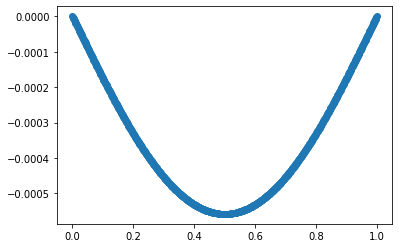

In [10]:
#plot the 1st entry of the dataframe
plt.scatter(fake_dataframe['x'][1],fake_dataframe['y'][1],label=str(fake_dataframe.index[1]))
plt.show()

In [11]:
#with the dataset organized is much easier to split the data.
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
#let's take a look at an example 
test_split=0.1 #we will use 10% of the data for testing. 
df = fake_dataframe
train_df, test_df = train_test_split(df, test_size = test_split)

In [12]:
#the training data will be spllited automatically by 80/20 during training using keras framework. 
# no need to split at this stage.
#let's check the array shapes: 
print('Training set: ',train_df.shape)
print('Test set: ',test_df.shape)

train_size = train_df.shape[0]
test_size = test_df.shape[0]

Training set:  (460800, 6)
Test set:  (51200, 6)


C:\Users\luisf\.conda\envs\tf\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


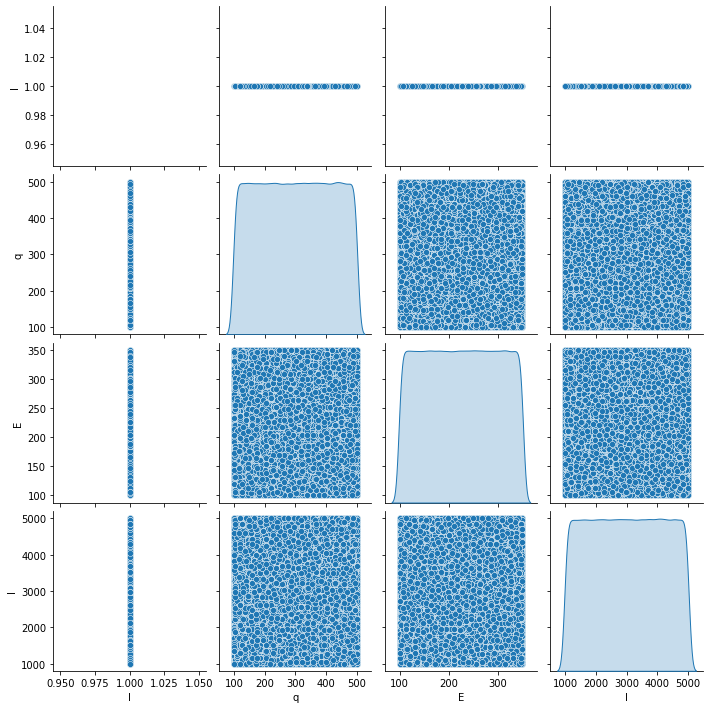

In [13]:
#inspect the training dataset
sns.pairplot(train_df[['l', 'q', 'E', 'I']], diag_kind='kde')

In [14]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
l,460800.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.0
q,460800.0,300.029778,116.936875,100.0,196.202532,302.531646,403.797468,500.0
E,460800.0,224.994980,73.059123,100.0,163.291139,226.582278,286.708861,350.0
I,460800.0,3000.959256,1168.959965,1000.0,2012.658228,3025.316456,4037.974684,5000.0


In [15]:
# follow this tutorial for our data 
# https://www.tensorflow.org/tutorials/keras/regression
# whenever possible, add comments and discussion

In [16]:
# I have fixed the value of L as 1.0 for now, so I am not using the values of [x,y] as inputs, only the values of y.

In [17]:
# Allocate the features and the labels in different DataFrames.

train_features = train_df.copy()
test_features = test_df.copy()

# train_labels = pd.DataFrame([train_features.pop('l'), train_features.pop('q'), train_features.pop('E'), train_features.pop('I')])
# train_labels = train_labels.T
# test_labels = pd.DataFrame([test_features.pop('l'), test_features.pop('q'), test_features.pop('E'), test_features.pop('I')])
# test_labels = test_labels.T

train_labels = pd.DataFrame([train_features.pop('q'), train_features.pop('E'), train_features.pop('I')])
train_labels = train_labels.T
test_labels = pd.DataFrame([test_features.pop('q'), test_features.pop('E'), test_features.pop('I')])
test_labels = test_labels.T

In [18]:
y_min_train = np.zeros(train_size)
y_min_test = np.zeros(test_size)


y_array_train = train_df.y.to_numpy()

for i in range(train_size):
    y_min_train[i] = np.min(y_array_train[i])

y_array_test = test_df.y.to_numpy()

for i in range(test_size):
    y_min_test[i] = np.min(y_array_test[i])

In [606]:
# Build the model and define its architecture.

In [607]:
inputs = keras.Input(shape=1)

In [608]:
dense = layers.Dense(256, activation="relu")
x = dense(inputs)

In [609]:
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(3)(x)

In [610]:
model = keras.Model(inputs=inputs, outputs=outputs, name="model")

In [611]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_48 (Dense)             (None, 256)               512       
_________________________________________________________________
dense_49 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_50 (Dense)             (None, 3)                 771       
Total params: 67,075
Trainable params: 67,075
Non-trainable params: 0
_________________________________________________________________


In [612]:
# Set the hyperparameters

validation_split = 0.2
learning_rate = 0.0008
batch_size = 50
epochs = 15

In [613]:
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
)

# Still need to find what's the best loss function for our model.

In [614]:
# For some reason I had to manually convert the data into tensors.

tf_train_features = tf.constant(y_min_train)

tf_train_labels = tf.constant([np.array(train_labels)], shape=(train_size,3))

tf_test_features = tf.constant(y_min_test)

tf_test_labels = tf.constant([np.array(test_labels)], shape=(test_size,3))

In [615]:
history = model.fit(tf_train_features, tf_train_labels, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

test_scores = model.evaluate(tf_train_features, tf_train_labels, verbose=2)
print("Test loss:", test_scores)

Epoch 1/15
7373/7373 [==============================] - 20s 3ms/step - loss: 607423.3125 - val_loss: 457856.3125
Epoch 2/15
7373/7373 [==============================] - 20s 3ms/step - loss: 453804.0312 - val_loss: 450628.6250
Epoch 3/15
7373/7373 [==============================] - 23s 3ms/step - loss: 444393.7188 - val_loss: 438708.8125
Epoch 4/15
7373/7373 [==============================] - 21s 3ms/step - loss: 423161.8125 - val_loss: 403006.7500
Epoch 5/15
7373/7373 [==============================] - 22s 3ms/step - loss: 361110.9375 - val_loss: 322746.1875
Epoch 6/15
7373/7373 [==============================] - 20s 3ms/step - loss: 304587.7812 - val_loss: 293577.3438
Epoch 7/15
7373/7373 [==============================] - 22s 3ms/step - loss: 292334.5000 - val_loss: 291549.9375
Epoch 8/15
7373/7373 [==============================] - 21s 3ms/step - loss: 291310.7812 - val_loss: 290646.5938
Epoch 9/15
7373/7373 [==============================] - 21s 3ms/step - loss: 290874.1250 - val_l

163683.0


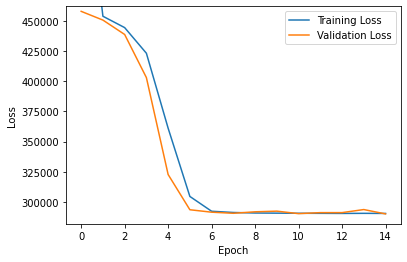

In [616]:
epochs = history.epoch

hist = history.history

plot_the_loss_curve(epochs, hist["loss"], 
                    hist["val_loss"])

In [617]:
tf_test_labels[0:5]

# q; E; I

<tf.Tensor: shape=(5, 3), dtype=float64, numpy=
array([[ 332.91139241,  182.27848101, 2367.08860759],
       [ 130.37974684,  194.93670886, 2721.51898734],
       [ 464.55696203,  131.64556962, 3784.81012658],
       [ 236.70886076,  207.59493671, 3784.81012658],
       [ 479.74683544,  226.58227848, 4037.97468354]])>

In [618]:
guesses = model.predict(tf_test_features)

guesses[0:5]
# q; E; I

array([[ 356.93567,  199.34167, 2541.7876 ],
       [ 224.84515,  253.21501, 3662.4985 ],
       [ 368.39835,  186.80463, 2295.1704 ],
       [ 249.50636,  245.33707, 3517.521  ],
       [ 322.04236,  220.53142, 2991.2896 ]], dtype=float32)

In [619]:
# relative error (%)

(np.abs(tf_test_labels[0:5] - model.predict(tf_test_features)[0:5]) / tf_test_labels[0:5]) * 100

<tf.Tensor: shape=(5, 3), dtype=float64, numpy=
array([[ 7.21641767,  9.36105771,  7.38033167],
       [72.45405001, 29.89601244, 34.57552757],
       [20.69899365, 41.89966818, 39.35837378],
       [ 5.40643139, 18.18066015,  7.06215428],
       [32.87243717,  2.67049156, 25.92104247]])>

In [620]:
error_mat = (np.abs(tf_test_labels - model.predict(tf_test_features)) / tf_test_labels) * 100

error_avg = np.array([0,0,0])
error_avg[0] = np.average(error_mat[:,0])
error_avg[1] = np.average(error_mat[:,1])
error_avg[2] = np.average(error_mat[:,2])

error_avg

# average relative error (%) for [q, E, I]

array([31, 27, 31])

In [621]:
def compare_curves(label, guess, n):

    label = [1, label[0], label[1],label[2]]
    guess = [1, guess[0], guess[1], guess[2]]
    
    x_vec = np.linspace(0, 1, n)
    y_vec = ana_sol(n, label)[1] * 10**3  # [mm]

    points = np.zeros((len(x_vec), 2))

    for i in range(len(x_vec)):
        points[i, 0] = x_vec[i]
        points[i, 1] = y_vec[i]
    
    y_vec_g = ana_sol(n, guess)[1] * 10**3  # [mm]

    points = np.zeros((len(x_vec), 2))

    for i in range(len(x_vec)):
        points[i, 0] = x_vec[i]
        points[i, 1] = y_vec[i]


    plt.plot(x_vec, y_vec, c='g')
    plt.plot(x_vec, y_vec_g, c='r')
    plt.show()

In [622]:
# error_col will contain the average of the relative errors (%) for q, E and I for each guess.

error_col = (error_mat[:,0] + error_mat[:,1] + error_mat[:,2])/3

In [623]:
np.average(error_col)

30.155055242617077

In [624]:
np.std(error_col)

21.15791042140319

In [625]:
np.max(error_col)

157.1491348296002

In [626]:
np.min(error_col)

0.3509756072770959

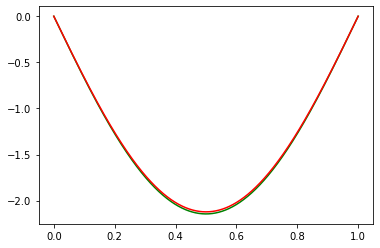

In [627]:
# This is the best guess (the guess which as the minimum average error)
# "True" curve is in green, whereas the "guessed" curve is in red.

min_label = np.array(tf_test_labels[np.argmin(error_col),:])
min_guess = model.predict(tf_test_features)[np.argmin(error_col),:]

compare_curves(min_label, min_guess, n)

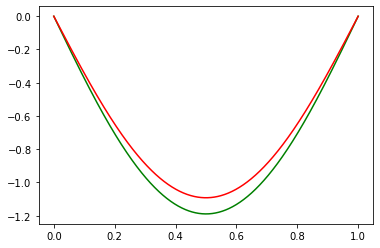

In [628]:
# This is the worst guess (the guess which as the maximum average error)

max_label = tf_test_labels[np.argmax(error_col),:]
max_guess = model.predict(tf_test_features)[np.argmax(error_col),:]

compare_curves(max_label, max_guess, n)

In [629]:
# We will use the relative error for the minimum value of y to evaluate the quality of the curves.

guess_curves = np.zeros([np.size(guesses, 0), n])
true_curves = np.zeros([np.size(guesses, 0), n])

for i in range(np.size(guesses, 0)):
    parameter_list = [1, guesses[i, 0], guesses[i,1], guesses[i,2]]
    guess_curves[i] = ana_sol(n, parameter_list)[1]
    
for i in range(np.size(guesses, 0)):
    true_parameter_list = [1, tf_test_labels[i, 0], tf_test_labels[i,1], tf_test_labels[i,2]]
    true_curves[i] = ana_sol(n, true_parameter_list)[1]
    
delta_y = np.abs(np.min(guess_curves, axis = 1) - np.min(true_curves, axis = 1))
rel_err_y = np.abs(delta_y / np.min(true_curves, axis = 1)) * 100

In [630]:
error_avg

array([31, 27, 31])

In [631]:
np.average(error_col)

30.155055242617077

In [632]:
np.std(error_col)

21.15791042140319

In [633]:
np.max(error_col)

157.1491348296002

In [634]:
np.min(error_col)

0.3509756072770959

In [635]:
np.average(rel_err_y)

7.104626008457509

In [636]:
np.std(rel_err_y)

8.262493202160073

In [637]:
np.max(rel_err_y)

237.1684913710455

In [638]:
np.min(rel_err_y)

4.664444185822259e-05

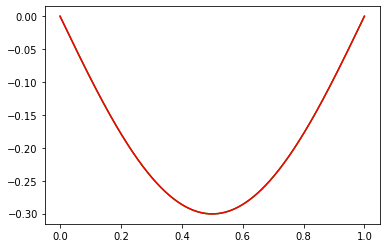

In [639]:
# Best curve

i_min_err = np.argmin(rel_err_y)
compare_curves(tf_test_labels[i_min_err,:], model.predict(tf_test_features)[i_min_err, :], n)

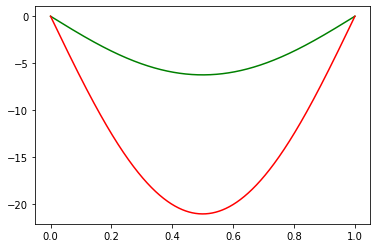

In [640]:
# Worst curve

i_max_err = np.argmax(rel_err_y)
compare_curves(tf_test_labels[i_max_err,:], model.predict(tf_test_features)[i_max_err ,:], n)

In [642]:
# 80x80x80 combinations:

# Rel. Error for [q, E, I]: [31, 27, 31] [32, 27, 30] [31, 27, 31](%) 

# Average Rel. Error:       30.16%    30.39%   30.24%
# Std for Rel. Error:       21.16%    20.99%   21.31%
# Max Rel. Error:           157.15%   155.02%  160.40%
# Min Rel. Error:           0.35%     0.32%    0.79%

# Rel. Error for y_min:     7.10%     7.86%    8.56%
# Std for y_min:            8.26%     12.83%   7.33%
# Max Rel. Error for y_min: 237.17%   205.00%  170.99%
# Min Rel. Error for y_min: 0.000047% 0.00019% 0.00020%

In [ ]:
# It appears that we were able to get acceptable accuracy in this experiment, altough slightly lower when compared to
# the regular model where we use all values of y (for the same number of [q, E, I] combinations).

# Running time is greatly reduced.

# This works very well in this case, but probably only because the beam is allways simetrical for this kind of load
# and the only key point is the minimum value of y.